## In This Notebook, The Goal Is To Apply **KMeans** Preceding GMCM And Access The Contribution

### Understanding the Application of KMeans to Transformed Data in Gaussian Mixture Models ###

### Original Data and Its Transformation:

Pick up three numerical columns in American Incomes Dataset. This data might have various distributions – for instance, age might be normally distributed, but hours-per-week could exhibit a more complex distribution.

#### Gaussian Copula Transformation:
- **Step 1**: Transform each column of your dataset into a uniform distribution using their respective cumulative distribution functions (CDFs).
- **Step 2**: Further transform these uniform distributions into a standard normal distribution using the inverse CDF of the Gaussian distribution.
- **Result**: The dataset now has each column following a standard normal distribution, while preserving the relationships between columns (like how hours-per-week and age are related).

### Why Apply KMeans to Transformed Data?

#### Applying KMeans:
- The transformed data is now in a space where the relationships between variables are more linear and Gaussian-like, which is ideal for KMeans clustering.
- KMeans clustering is most effective when the clusters are roughly spherical and the data within each cluster follows a Gaussian distribution. The transformation process makes the data more suitable for KMeans to identify meaningful clusters.

### Using KMeans Results for GMM Initialization:

#### GMM Initialization:
- The centroids (means) of the KMeans clusters provide good starting points for the means of the Gaussian components in the Gaussian Mixture Model (GMM).
- Since these centroids represent the central points of different groups in your data, they are logical choices for the initial means in a model that aims to capture the data's distribution.

### Conclusion:

By applying KMeans to the transformed dataset, meaningful clusters can be identified in the context of Gaussian distributions. These clusters then aid in initializing the GMM more effectively, leading to a better model that captures the underlying patterns and relationships in the original data.


In [831]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from collections import defaultdict
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm

from scipy.optimize import brentq

from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
tqdm.pandas()
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings(action='ignore')
import scipy.stats as stats
import seaborn as sns

# import seaborn as sns

In [832]:
data = pd.read_csv("American_Income.csv")

In [833]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [834]:
data_info = data.dtypes.to_dict()

In [835]:
data_info

{'age': dtype('int64'),
 ' workclass': dtype('O'),
 ' fnlwgt': dtype('int64'),
 ' education': dtype('O'),
 ' education-num': dtype('int64'),
 ' marital-status': dtype('O'),
 ' occupation': dtype('O'),
 ' relationship': dtype('O'),
 ' race': dtype('O'),
 ' sex': dtype('O'),
 ' capital-gain': dtype('int64'),
 ' capital-loss': dtype('int64'),
 ' hours-per-week': dtype('int64'),
 ' native-country': dtype('O'),
 ' salary': dtype('O')}

In [836]:
'''group the column into numerical column and category column
   Generating two listes contains numerical columns and category columns
'''

num_column = []
category_column = []
for key in data_info.keys():
    if data_info[key] == 'int64':
        num_column.append(key)
    if data_info[key] == 'object':
        category_column.append(key)

### Select age and hours-per-week and fnlwgt

In [837]:
def best_fit_distribution(column_data):
    # Define the distributions to test
    distributions = ['norm', 'uniform', 'beta', 'expon', 'truncnorm']  ## mentioned in the SDV paper
    best_fit = None
    best_p_value = -1

    # Test each distribution
    for distribution in distributions:
        if distribution == 'norm':
            params = norm.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)  ## Compare by using KStest
        elif distribution == 'uniform':
            params = uniform.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'beta':
            # Beta distribution requires data to be in (0, 1) range
            epsilon = 1e-10
            scaled_data = (column_data - column_data.min() + epsilon) / (column_data.max() - column_data.min() + 2 * epsilon)
            params = beta.fit(scaled_data, floc=0, fscale=1)
            D, p_value = kstest(scaled_data, distribution, args=params)
        elif distribution == 'expon':
            params = expon.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'truncnorm':
            mean,std_dev = norm.fit(column_data)
            lower_bound = (column_data.min() - mean)/std_dev
            upper_bound = (column_data.max() - mean)/ std_dev
            params = truncnorm.fit(column_data, lower_bound, upper_bound)
            D,p_value = kstest(column_data,distribution, args= params)

        if p_value > best_p_value:
            best_p_value = p_value
            best_fit = distribution

    return best_fit, best_p_value

In [838]:
age_hours_df = data[['age', ' hours-per-week', ' fnlwgt']]

In [839]:
## Check Which Distribution in each column
distribution = {}
for column in age_hours_df.columns:
    best_fit, best_p_value = best_fit_distribution(age_hours_df[column])
    distribution[column] = best_fit

distribution

{'age': 'norm', ' hours-per-week': 'norm', ' fnlwgt': 'beta'}

In [840]:
def calculate_normal_cdf(data):
    """
    Calculates the Cumulative Distribution Function (CDF) values of normal distribution.

    :param data: Pandas Series or numpy array containing the data.
    :return: A pandas DataFrame with original values and their corresponding CDF values.
    """
    # Calculate the mean and standard deviation of the data
    mean = data.mean()
    std = data.std()

    # Calculating the CDF values using the normal distribution
    cdf_values = norm.cdf(data, loc=mean, scale=std)

    return cdf_values, mean, std


def calculate_beta_cdf(data):
    """
    Calculates the Cumulative Distribution Function (CDF) values of a beta distribution.

    :param data: Pandas Series or numpy array containing the data.
    :return: A pandas DataFrame with original values and their corresponding CDF values.
    """
    # Normalizing data to the range [0, 1] for the beta distribution
    data_normalized = (data - data.min()) / (data.max() - data.min())

    # Estimate the parameters of the beta distribution
    a, b, loc, scale = beta.fit(data_normalized)

    # Calculating the CDF values using the beta distribution
    cdf_values = beta.cdf(data_normalized, a, b, loc, scale)

    return cdf_values, data.min(), data.max(), a ,b, loc, scale


def inverse_standard_normal(p_values):
    """
    Compute the inverse CDF (quantile function) of the GMM for a given probability p.
    
    Parameters:
    - p: Probability for which to compute the inverse CDF
    
    Returns:
    - x value such that gmm_cdf(x, gmm) = p
    """
    return norm.ppf(p_values)




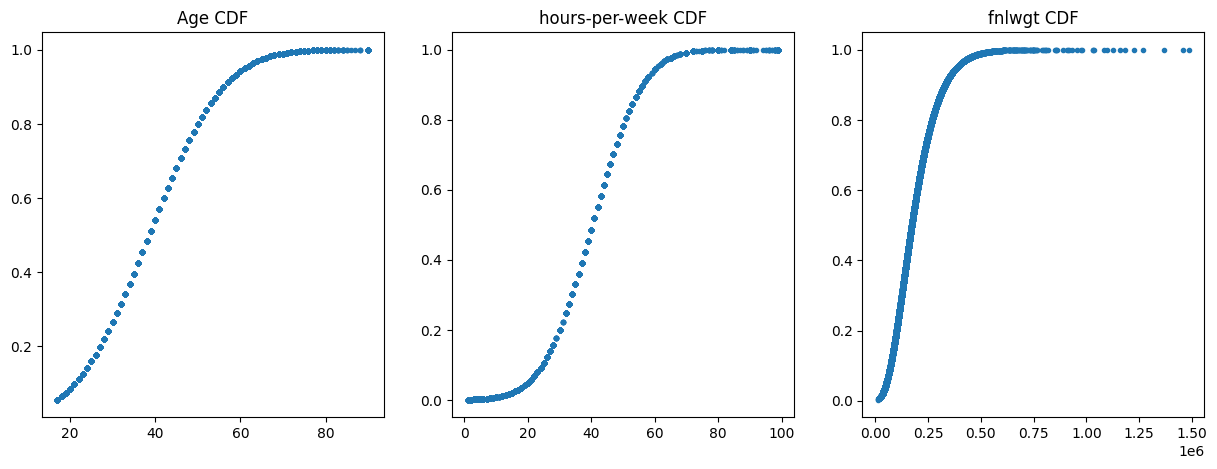

<Figure size 1000x600 with 0 Axes>

In [841]:
# Calculating the CDF values for the 'age' column
age_cdf, age_mean, age_std = calculate_normal_cdf(data['age'])

# Calculating the CDF values for the ' hours-per-week' column
hours_cdf, hours_mean, hours_std = calculate_normal_cdf(data[' hours-per-week'])

# Calculating the CDF values for the ' fnlwgt' column
fnlwgt_cdf, minf, maxf, af, bf, locf, scalef = calculate_beta_cdf(data[' fnlwgt'])




# Show CDF of each columns
df = pd.DataFrame()
df['age'] = data['age']
df['ageCDF'] = age_cdf
df[' hours-per-week'] = data[' hours-per-week']
df['hoursCDF'] = hours_cdf
df[' fnlwgt'] = data[' fnlwgt']
df['fnlwgtCDF'] = fnlwgt_cdf


fig,axs = plt.subplots(1,3,figsize = (15,5))
# Plotting the calculated normal CDF values against the age
plt.figure(figsize=(10, 6))
axs[0].scatter(df['age'], df['ageCDF'], marker='.')
axs[1].scatter(df[' hours-per-week'], df['hoursCDF'], marker='.')
axs[2].scatter(df[' fnlwgt'], df['fnlwgtCDF'], marker='.')
axs[0].set_title('Age CDF')
axs[1].set_title('hours-per-week CDF')
axs[2].set_title('fnlwgt CDF')
plt.show()


In [842]:
"""
    Gaussian Copula
    inverse CDF of the standard normal distribution
"""

inverse_standard_normal_df = pd.DataFrame()

inverse_standard_normal_df["age_inv_cdf_stand"] = df['ageCDF'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["hours_inv_cdf_stand"] = df['hoursCDF'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["fnlwgt_inv_cdf_stand"] = df['fnlwgtCDF'].apply(lambda p_value: inverse_standard_normal(p_value))

In [843]:
# Show result
inverse_standard_normal_df

covariance_matrix = inverse_standard_normal_df.cov()  # Used for comparison later

### Applies Kmeans to transformed dataset

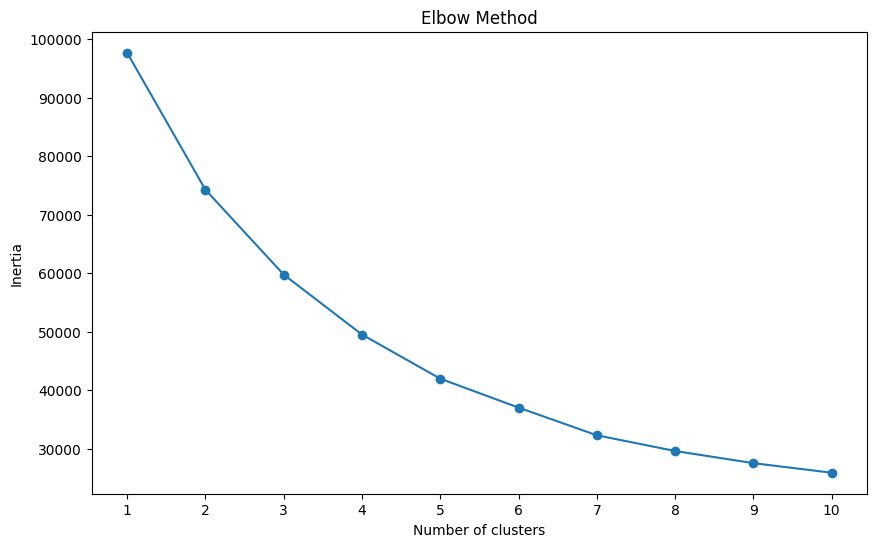

In [844]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(inverse_standard_normal_df)

# Applying the Elbow method to find the optimal number of clusters
inertia = []
range_of_clusters = range(1, 11)

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

num_of_cluster = 4

In [845]:
kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
kmeans.fit(inverse_standard_normal_df)
labels = kmeans.labels_
inverse_standard_normal_df['label'] = labels
inverse_standard_normal_df

,age_inv_cdf_stand,hours_inv_cdf_stand,fnlwgt_inv_cdf_stand,label
0,0.030670,-0.035429,-1.186195,2
1,0.837096,-2.222119,-1.094362,1
2,-0.042641,-0.035429,0.404082,3
3,1.057031,-0.035429,0.566885,1
4,-0.775756,-0.035429,1.335040,3
...,...,...,...,...
32556,-0.849067,-0.197406,0.749507,3
32557,0.103982,-0.035429,-0.187890,2
32558,1.423588,-0.035429,-0.214478,1
32559,-1.215625,-1.655199,0.277496,3


In [846]:
inverse_standard_normal_df.to_csv("inverse_standard_normal_df.csv")

In [847]:
# Calculating summary statistics for each cluster
cluster_summary = inverse_standard_normal_df.groupby('label').agg(['mean', 'median', 'std'])

cluster_summary


age_inv_cdf_stand                     hours_inv_cdf_stand            \
                   mean    median       std                mean    median   
label                                                                       
0              0.142842  0.103982  0.697315            1.526955  1.584342   
1              1.235984  1.130342  0.661102           -0.292232 -0.035429   
2             -0.392378 -0.409199  0.678875           -0.138351 -0.035429   
3             -0.670441 -0.702444  0.560931           -0.315322 -0.035429   

                fnlwgt_inv_cdf_stand                      
            std                 mean    median       std  
label                                                     
0      0.854912             0.027371  0.057937  0.819487  
1      0.797658             0.028210  0.031886  0.754419  
2      0.726347            -1.159362 -0.998924  0.624299  
3      0.747168             0.683821  0.505483  0.708959

In [848]:
inverse_standard_normal_df.iloc[:,0:3]

,age_inv_cdf_stand,hours_inv_cdf_stand,fnlwgt_inv_cdf_stand
0,0.030670,-0.035429,-1.186195
1,0.837096,-2.222119,-1.094362
2,-0.042641,-0.035429,0.404082
3,1.057031,-0.035429,0.566885
4,-0.775756,-0.035429,1.335040
...,...,...,...
32556,-0.849067,-0.197406,0.749507
32557,0.103982,-0.035429,-0.187890
32558,1.423588,-0.035429,-0.214478
32559,-1.215625,-1.655199,0.277496


- **Cluster 0**:
    1. **age_inv_cdf_stand**: Slightly above-average age.
    2. **hours_inv_cdf_stand**: Significantly above-average hours per week, suggesting this cluster might represent individuals with longer working hours.
    3. **fnlwgt_inv_cdf_stand**: Around average 'fnlwgt'.
- **Cluster 1**:
    1. **age_inv_cdf_stand**: Highest average age, indicating this cluster primarily consists of older individuals.
    2. **hours_inv_cdf_stand**: Below-average hours per week, possibly part-time workers or retirees
    3. **fnlwgt_inv_cdf_stand**: Similar to Cluster 0 in 'fnlwgt'.
- **Cluster 2**:
    1. **age_inv_cdf_stand**: Below-average age, indicating a younger demographic.
    2. **hours_inv_cdf_stand**: Slightly below-average hours per week.
    3. **fnlwgt_inv_cdf_stand**: Significantly below average, suggesting a different demographic or socioeconomic status.
- **Cluster 3**:
    1. **age_inv_cdf_stand**: The lowest average age, indicating the youngest demographic.
    2. **hours_inv_cdf_stand**: Similar to Cluster 1, indicating lower working hours.
    3. **fnlwgt_inv_cdf_stand**: Above-average 'fnlwgt', distinguishing this cluster from the others.
### Summary:
Apply **KMeans** Indeed can find some realtionships among the columns

In [849]:
centroids = kmeans.cluster_centers_
centroids

array([[ 0.14248857,  1.52699171,  0.02965862],
       [ 1.23483932, -0.29202188,  0.02983913],
       [-0.38893894, -0.13478212, -1.16251915],
       [-0.67251562, -0.31681684,  0.68130323]])

In [850]:
gmm = GaussianMixture(n_components=num_of_cluster, covariance_type='full', random_state=0)

gmm.means_init = centroids ## Initial the means to let the apply components on different cluster

gmm.fit(inverse_standard_normal_df.iloc[:,0:3])


GaussianMixture(means_init=array([[ 0.14248857,  1.52699171,  0.02965862],
       [ 1.23483932, -0.29202188,  0.02983913],
       [-0.38893894, -0.13478212, -1.16251915],
       [-0.67251562, -0.31681684,  0.68130323]]),
                n_components=4, random_state=0)

In [851]:
synthetic_overall = gmm.sample(len(inverse_standard_normal_df))[0]

In [852]:
synthetic_overall

column_names = ['age', 'hours-per-week', 'fnlwgt']
synthetic_overall_df = pd.DataFrame(synthetic_overall, columns=column_names)


synthetic_overall_df

covariance_matrix1 = synthetic_overall_df.cov() ##used for the comparison later

In [853]:
inverse_standard_normal_df

,age_inv_cdf_stand,hours_inv_cdf_stand,fnlwgt_inv_cdf_stand,label
0,0.030670,-0.035429,-1.186195,2
1,0.837096,-2.222119,-1.094362,1
2,-0.042641,-0.035429,0.404082,3
3,1.057031,-0.035429,0.566885,1
4,-0.775756,-0.035429,1.335040,3
...,...,...,...,...
32556,-0.849067,-0.197406,0.749507,3
32557,0.103982,-0.035429,-0.187890,2
32558,1.423588,-0.035429,-0.214478,1
32559,-1.215625,-1.655199,0.277496,3


In [854]:
def inverse_cdf_age(age_cdf, age_mean, age_std):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(age_cdf, loc=age_mean, scale=age_std)

    return original_values
def inverse_cdf_hours(hours_cdf, hours_mean, hours_std):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(hours_cdf, loc=hours_mean, scale=hours_std)

    return original_values

def inverse_cdf_fnlwgt(fnlwgt_cdf, minf, maxf, af, bf, locf, scalef):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a beta distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_min: Minimum value of the original data.
    :param data_max: Maximum value of the original data.
    :param a, b: Parameters of the beta distribution (shape parameters).
    :param loc, scale: Location and scale parameters of the beta distribution.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF (PPF) values
    normalized_values = beta.ppf(fnlwgt_cdf, af, bf, locf, scalef)

    # Transforming the normalized values back to the original scale
    original_values = normalized_values * (maxf - minf) + minf

    return original_values

F_inv = [inverse_cdf_age, inverse_cdf_hours, inverse_cdf_fnlwgt]

In [855]:
def sample(F_inv, Sigma, age_mean, age_std, hours_mean, hours_std, fnlwgt_params):
    """
    Sample numerical values from the distribution and covariances of the columns.
    
    Parameters:
    - F_inv: A list of inverse CDF functions for the marginals.
    - Sigma: The covariance matrix.
    - age_mean, age_std: Mean and std for age.
    - hours_mean, hours_std: Mean and std for hours-per-week.
    - fnlwgt_params: Parameters for fnlwgt's beta distribution.
    
    Returns:
    - A sample vector x in the original space.
    """
    # Step 2: Random n-dimensional Gaussian vector
    n = Sigma.shape[0]
    v = np.random.randn(n)
    
    # Step 3: Cholesky decomposition
    L = np.linalg.cholesky(Sigma)
    
    # Step 4: u ← Lv
    u = L.dot(v)
    
    # Step 5: x ← [F_0^(-1)(Φ(u_0)), F_1^(-1)(Φ(u_1)), ..., F_n^(-1)(Φ(u_n))]
    x = [
        inverse_cdf_age(norm.cdf(u[0]), age_mean, age_std),
        inverse_cdf_hours(norm.cdf(u[1]), hours_mean, hours_std),
        inverse_cdf_fnlwgt(norm.cdf(u[2]), *fnlwgt_params)
    ]

    return x


age_mean = age_mean
age_std = age_std
hours_mean = hours_mean
hours_std = hours_std
fnlwgt_params = (minf, maxf, af, bf, locf, scalef) 

num_rows = age_hours_df.shape[0] 
synthetic_dataset = [sample(F_inv, covariance_matrix1, age_mean, age_std, hours_mean, hours_std, fnlwgt_params) for _ in range(num_rows)]
synthetic_df_full = pd.DataFrame(synthetic_dataset, columns=['age', ' hours-per-week',' fnlwgt'])


In [856]:
age_mean = age_mean
age_std = age_std
hours_mean = hours_mean
hours_std = hours_std
fnlwgt_params = (minf, maxf, af, bf, locf, scalef) 

num_rows = age_hours_df.shape[0] 
synthetic_dataset1 = [sample(F_inv, covariance_matrix, age_mean, age_std, hours_mean, hours_std, fnlwgt_params) for _ in range(num_rows)]
synthetic_df_full1 = pd.DataFrame(synthetic_dataset1, columns=['age', ' hours-per-week',' fnlwgt'])

In [857]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [858]:
synthetic_df_full

,age,hours-per-week,fnlwgt
0,61.567372,35.876507,52053.591475
1,51.096280,25.546493,353566.482770
2,22.727767,37.692996,121878.173435
3,30.958545,57.398426,131359.987171
4,22.434544,25.645865,77025.298163
...,...,...,...
32556,3.027575,24.647291,286657.556154
32557,9.428647,35.100843,187458.871936
32558,42.369823,38.492077,451222.772846
32559,48.713999,41.506752,205315.130520


In [870]:
synthetic_df_full1

,age,hours-per-week,fnlwgt
0,57.802255,32.282734,60884.614912
1,50.170174,18.033331,208940.062591
2,19.117710,39.523650,323746.043823
3,42.607274,53.676176,129738.193129
4,57.384203,59.107697,103482.378323
...,...,...,...
32556,44.713758,24.691493,29554.190911
32557,34.304613,35.468650,189106.468192
32558,45.940363,56.424582,86054.745040
32559,48.467594,46.183916,153963.548332


## Comparison

In [859]:
def boundary_adherence(original_data, synthetic_data, column_names):
    """
    Compute the Boundary Adherence for multiple numerical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute Boundary Adherence for.

    Returns:
    - Dictionary with Boundary Adherence scores for the specified columns.
    """
    results = {}
    
    for column_name in column_names:
        min_val = original_data[column_name].min()
        max_val = original_data[column_name].max()
        
        adhering_values = synthetic_data[(synthetic_data[column_name] >= min_val) & (synthetic_data[column_name] <= max_val)]
        
        results[column_name] = len(adhering_values) / len(synthetic_data)
    
    return results


def range_coverage(original_data, synthetic_data, column_names):
    """
    Compute the Range Coverage for multiple numerical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute Range Coverage for.

    Returns:
    - Dictionary with Range Coverage scores for the specified columns.
    """
    
    coverage_results = {}
    
    for column_name in column_names:
        # Determine the support (range) of the original data
        min_r = original_data[column_name].min()
        max_r = original_data[column_name].max()

        # Determine the support (range) of the synthetic data
        min_s = synthetic_data[column_name].min()
        max_s = synthetic_data[column_name].max()

        # Calculate the components of the Range Coverage formula
        component_1 = max((min_s - min_r) / (max_r - min_r), 0)
        component_2 = max((max_r - max_s) / (max_r - min_r), 0)

        # Calculate Range Coverage score
        coverage_score = 1 - component_1 - component_2
        
        # Store the result in the dictionary
        coverage_results[column_name] = coverage_score
    
    return coverage_results




In [860]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)

baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_df_full, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

num_of_cluster

Creating report: 100%|██████████| 4/4 [00:00<00:00, 52.10it/s]


Overall Quality Score: 94.05%

Properties:
Column Shapes: 88.24%
Column Pair Trends: 99.86%


4

In [869]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)

baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_df_full1, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

num_of_cluster

Creating report: 100%|██████████| 4/4 [00:00<00:00, 51.59it/s]


Overall Quality Score: 93.96%

Properties:
Column Shapes: 88.17%
Column Pair Trends: 99.75%


4

In [861]:
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_df_full,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

In [862]:
fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_df_full,
    column_name='age',
    metadata=metadata1
)
    
fig.show()

In [863]:
fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_df_full,
    column_name=' fnlwgt',
    metadata=metadata1
)
    
fig.show()

In [864]:
metadata1 = SingleTableMetadata()

metadata1.detect_from_dataframe(data = age_hours_df)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(age_hours_df)
synthetic_data = synthesier.sample(num_rows = num_rows)  #keep the number of rows equal to the data hold
synthetic_data 

,age,hours-per-week,fnlwgt
0,40,50,76633
1,45,39,282869
2,43,33,154860
3,58,22,265018
4,55,44,175927
...,...,...,...
32556,31,50,177945
32557,19,28,210191
32558,56,61,67540
32559,39,34,415682


In [865]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)

baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_data, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 49.86it/s]


Overall Quality Score: 94.23%

Properties:
Column Shapes: 89.81%
Column Pair Trends: 98.64%


In [866]:
fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_data,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

In [867]:
fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_data,
    column_name='age',
    metadata=metadata1
)
    
fig.show()

In [868]:
fig = get_column_plot(
    real_data=age_hours_df,
    synthetic_data=synthetic_data,
    column_name=' fnlwgt',
    metadata=metadata1
)
    
fig.show()